# Geospatial ES|QL

## Resources

* Craig's content in [Search Labs](https://www.elastic.co/search-labs/author/craig-taverner)
* [Spatial functions documentation](https://www.elastic.co/docs/reference/query-languages/esql/functions-operators/spatial-functions)
* [Run this notebook in Google Colaboratory](https://colab.research.google.com/github/jsanz/foss4g_europe_lab/blob/main/03-geospatial_esql.ipynb)

## Setup

In [1]:
# Install required dependencies
!pip install -qU elasticsearch geopandas matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 929.5/929.5 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.1/65.1 kB 2.8 MB/s eta 0:00:00


Start with the necessary imports, a couple tweaks, and defining a "esql" query that will make easier to see the results of a query, by generating a Pandas or Geopandas dataframe.

In [2]:

import os
import io

import warnings

from elasticsearch import Elasticsearch
from elasticsearch import ElasticsearchWarning
from elasticsearch.exceptions import BadRequestError

import pandas as pd
import geopandas as gpd
from shapely import wkb

# Hide the warning when no LIMIT is passed on a ES|QL query
warnings.filterwarnings('ignore', category=ElasticsearchWarning)

# Allow wide columns
pd.set_option('display.max_colwidth', None)

# Convert Well-known Binary to Text
def wkb_to_wkt(wkb_bytes):
    if wkb_bytes is None:
        return None
    try:
        return wkb.loads(wkb_bytes).wkt
    except Exception as e:
        print(f"Error converting WKB: {wkb_bytes} - {e}")
        return None

# Generate a Pandas Dataframe or a Geopandas Dataframe from a ES|QL query
def esql(query, geometry_col:str = "geometry", use_arrow:bool = False):
    try:
        # Query ES and create a Pandas Dataframe
        if use_arrow:
            es_response = client.esql.query(query=query.strip(), format="arrow", columnar=True)
            df = es_response.to_pandas()
        else:
            es_response = client.esql.query(query=query.strip(), format="csv")
            df = pd.read_csv(io.StringIO(str(es_response)))

        # Promote to a Geopandas Dataframe if a "geometry" column
        if geometry_col in df.columns:
            if use_arrow:
                # Arrow geometries are transferred as WKB
                df[geometry_col] = df[geometry_col].apply(wkb_to_wkt)
            gs = gpd.GeoSeries.from_wkt(df[geometry_col])
            gdf = gpd.GeoDataFrame(df, geometry=gs, crs="EPSG:4326")
            if geometry_col != "geometry":
                gdf.drop(columns="geometry")
            return gdf
        else:
            return df
    except BadRequestError as e:
        print("Something went wrong!")
        print(e.message)
        print("\r\n".join([c['reason'] for c in e.info['error']['root_cause']]))

Connect to Elasticsearch and print some cluster details

In [3]:
# Login details
ES_URL=os.getenv("ES_URL","https://siglibre2025.es.us-central1.gcp.cloud.es.io")
KB_URL=os.getenv("KB_URL","https://siglibre2025.kb.us-central1.gcp.cloud.es.io")

# API key that allows reading indices
ES_APIKEY=os.getenv("ES_APIKEY", "NUF3RDlwZ0IxNDhsNzFFOXFDRWs6VS1xT1NKbTlGckdiMXdxVlBVd3RiQQ==")

# Load the client
client = Elasticsearch(hosts=[ES_URL], api_key=ES_APIKEY)

# Check the client
if client.ping():
  print("Connected to Elasticsearch")
  c_info = client.info()
  is_serverless = c_info['version']['build_flavor'] == 'serverless'

  # Print some cluster details
  print(f"Elasticsearch URL: {ES_URL}")
  print(f"Cluster name: {c_info['name']}")
  print(f"Version: {c_info['version']['number'] if not is_serverless else 'serverless'}")
  print("Number of documents indexed: ", client.count(index="*")['count'])
else:
  print("Connection failed")


Connected to Elasticsearch
Elasticsearch URL: https://siglibre2025.es.us-central1.gcp.cloud.es.io
Cluster name: instance-0000000003
Version: 9.1.3
Number of documents indexed:  524990


## Geospatial types and conversions

Let's render some Well Known Text geometry representations from the [Wikipedia page](https://en.wikipedia.org/wiki/Well-known_text_representation_of_geometry) to test the `TO_GEOSHAPE` function. There's also a `TO_GEOPOINT` function if you are only working with point geometries.

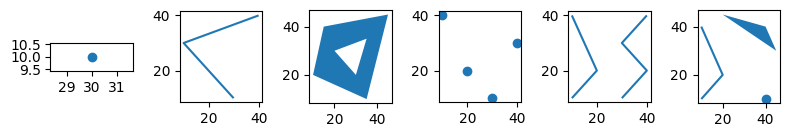

In [4]:
import matplotlib.pyplot as plt

wkt_tests = [
    "POINT (30 10)",
    "LINESTRING (30 10, 10 30, 40 40)",
    "POLYGON ((35 10, 45 45, 15 40, 10 20, 35 10),(20 30, 35 35, 30 20, 20 30))",
    "MULTIPOINT (10 40, 40 30, 20 20, 30 10)",
    "MULTILINESTRING ((10 10, 20 20, 10 40),(40 40, 30 30, 40 20, 30 10))",
    "GEOMETRYCOLLECTION (POINT (40 10), LINESTRING (10 10, 20 20, 10 40), POLYGON ((40 40, 20 45, 45 30, 40 40)))"
]

fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(8, 8))

for index, wkt in enumerate(wkt_tests):
  # Define a WKT point and cast it to a geo_point
  esql(
  f"""
  ROW wkt = "{wkt}"
  | EVAL geometry=TO_GEOSHAPE(wkt)
  | KEEP geometry
  """).plot(ax=axes[index])

plt.tight_layout()
plt.show()

## Extract coordinates: `ST_X` and `ST_Y`

In [6]:
esql("""
FROM places-*
| WHERE geometry IS NOT NULL
| EVAL lat = ROUND(ST_Y(geometry),5),
       lon = ROUND(ST_X(geometry),5)
| KEEP name, category, lon, lat
| LIMIT 10
""")

,name,category,lon,lat
0,Pantano De Canoves,active_life,2.34390,41.71782
1,Embalse de Vallfornés,structure_and_geography,2.34202,41.71998
2,Hotel Can Cuch,hotel,2.34867,41.72493
3,El Bastión del Espino,landmark_and_historical_building,2.36137,41.71496
4,Ermita de Sant Salvador,religious_organization,2.35151,41.72199
5,Pantà de Vallforners,national_park,2.35069,41.72841
6,La Casa del Bosc,restaurant,2.35002,41.73749
7,Turó del Samont,landmark_and_historical_building,2.36639,41.74277
8,Castell de Fluvià,accommodation,2.41460,41.72188
9,El Castell de Fluvià,hotel,2.41454,41.72226


## Distance computations

 Let's find the [GeoChicas take Mostar](https://2025.europe.foss4g.org/schedule/geochicas-take-mostar/) venue by searching in our `places-bosnia` index and save the first result.

In [7]:
charlie = esql("""
FROM places-bosnia
| WHERE name like "Charlie Bar and Snack"
| LIMIT 1
""")

if len(charlie.index) == 0:
  print("No results found!")
else:
  charlie_feature = charlie.iloc[0]
  print(charlie_feature['name'])
  print(f"Categories: {charlie_feature['category']} - {charlie_feature['alt_categories']}")
  print(f"Contact: ☎ {charlie_feature['phones']}, {charlie_feature['websites']}")
  print(charlie_feature['geometry'])

Charlie Bar and Snack
Categories: bar - [fast_food_restaurant, professional_services]
Contact: ☎ 38763100400, https://charlie.ba/
POINT (17.7950102 43.3440312)



    FROM places-bosnia
    | EVAL dist_charlie = ST_DISTANCE(TO_GEOPOINT("POINT (17.7950102 43.3440312)"), geometry)
    | WHERE dist_charlie < 1000
    | KEEP name, category, dist_charlie, geometry
    | LIMIT 50000
    


<Axes: >

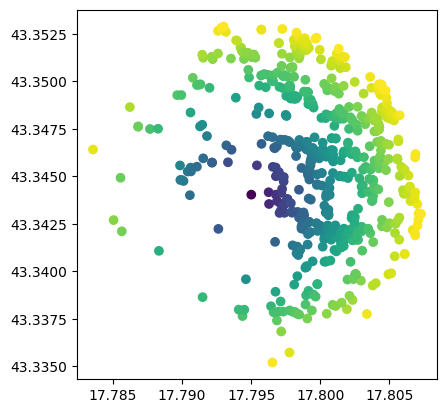

In [8]:
# Save the distance in a field, then use it to
# filter all geometries and thematic mapping
query = f"""
    FROM places-bosnia
    | EVAL dist_charlie = ST_DISTANCE(TO_GEOPOINT("{charlie_feature["geometry"]}"), geometry)
    | WHERE dist_charlie < 1000
    | KEEP name, category, dist_charlie, geometry
    | LIMIT 50000
    """
print(query)
esql(query).plot(column="dist_charlie")

We'll use that query later in Kibana.

## Geometry aggregation: `ST_EXTENT_AGG` , and `ST_CENTROID_AGG` and geometry functions `ST_ENVELOPE`, `ST_XMAX`, `ST_YMAX`, etc.

In [9]:
# Get the envelope of a geometry, this function only works on single rows
# We use the use_arrow=False param in our helper function to return the
# envelope as a WKT instead of a binary.
query = f"""
    FROM ne_countries
    | WHERE iso_a2 LIKE "BA"
    | EVAL geometry_envelope = ST_ENVELOPE(geometry)
    | KEEP name, geometry_envelope
    | LIMIT 1
    """
esql(query, use_arrow=False)

,name,geometry_envelope
0,Bosnia and Herz.,"BBOX (15.716073852000108, 19.618884725000044, 45.28452382500008, 42.55921213800009)"


In [11]:
# To play with the centroid aggregation and the other geometry functions let's
# try the following:
# 1- Compute the distance
# 2- Filter those 1km away from Charlie's
# 3- Grouping places by category, get the count, envelope, and centroid
# 4- Filter only categories with more than 10 results
# 5- Get the boundaries of the envelopes
# 6- For each row, print the category, count, boundaries, and
#    centroid geometry, sorting by counts

query = f"""
    FROM places-bosnia
    // First compute the distance to Charlie Bar and Snack
    | EVAL dist_charlie = ST_DISTANCE(TO_GEOPOINT("{charlie_feature["geometry"]}"), geometry)

    // Filter those within a kilometer
    | WHERE dist_charlie < 1000

    // Compute the count, and grouping by category,
    // aggregate the envelope and centroid geometries
    | STATS count = COUNT(),
            geometry_envelope = ST_EXTENT_AGG(geometry),
              centroid = ST_CENTROID_AGG(geometry)
              BY category

    // Filter those categories wtih less than 10 venues
    | WHERE count > 10

    // Compute the envelope bounds
    | EVAL lat_max = ST_YMAX(geometry_envelope),
             lon_max = ST_XMAX(geometry_envelope),
             lat_min = ST_YMIN(geometry_envelope),
             lon_min = ST_XMIN(geometry_envelope)
    | KEEP count, category, lat_max, lon_max, lat_min, lon_min, centroid
    | SORT count DESC
    """
print(query)
esql(query, use_arrow=False)


    FROM places-bosnia
    // First compute the distance to Charlie Bar and Snack
    | EVAL dist_charlie = ST_DISTANCE(TO_GEOPOINT("POINT (17.7950102 43.3440312)"), geometry)

    // Filter those within a kilometer
    | WHERE dist_charlie < 1000

    // Compute the count, and grouping by category,
    // aggregate the envelope and centroid geometries
    | STATS count = COUNT(),
            geometry_envelope = ST_EXTENT_AGG(geometry),
              centroid = ST_CENTROID_AGG(geometry)
              BY category

    // Filter those categories wtih less than 10 venues
    | WHERE count > 10

    // Compute the envelope bounds
    | EVAL lat_max = ST_YMAX(geometry_envelope),
             lon_max = ST_XMAX(geometry_envelope),
             lat_min = ST_YMIN(geometry_envelope),
             lon_min = ST_XMIN(geometry_envelope)
    | KEEP count, category, lat_max, lon_max, lat_min, lon_min, centroid
    | SORT count DESC
    


,count,category,lat_max,lon_max,lat_min,lon_min,centroid
0,43,beauty_salon,43.352649,17.804928,43.335197,17.788327,POINT (17.799854400719322 43.34607028456535)
1,41,cafe,43.351507,17.805411,43.337764,17.787678,POINT (17.79920478601281 43.34575539647897)
2,20,college_university,43.352563,17.807274,43.341363,17.789852,POINT (17.797850808128715 43.34477888094261)
3,19,bar,43.351300,17.804279,43.341869,17.786222,POINT (17.79920242971888 43.34628158567571)
4,18,professional_services,43.352752,17.806833,43.338247,17.791080,POINT (17.80015525408089 43.34577495697886)
5,15,restaurant,43.351444,17.804731,43.337513,17.797221,POINT (17.8010140825063 43.34602358657867)
6,14,hospital,43.350711,17.805390,43.337865,17.789876,POINT (17.797520836549147 43.34567683782162)
7,14,community_services_non_profits,43.349486,17.804020,43.337938,17.792170,POINT (17.799646906288608 43.34396989018257)
8,12,shopping,43.351172,17.803711,43.341148,17.783554,POINT (17.798194403294474 43.34646971896291)
9,11,pizza_restaurant,43.352293,17.806487,43.339894,17.798225,POINT (17.801724999973718 43.34623912772672)


## Geometry comparisons: `ST_INTERSECTS`, `ST_WITHIN`, etc

To filter by spatial relationships, OGC describes a set of `ST_` functions that check if two geometries intersect, are completely covered, or disjoint, etc. ES|QL supports `ST_INTERSECTS`, `ST_DISJOINT`, `ST_CONTAINS`, and `ST_WITHIN`

In [12]:
# Let's find geometries
# by intersecting them against a buffer
BUFFER_DISTANCE = 0.01
SIMPLIFY_TOLERANCE = 0.0005

charlie_buffer = charlie.copy()
charlie_buffer["geometry"] = charlie_buffer["geometry"].buffer(BUFFER_DISTANCE).simplify(SIMPLIFY_TOLERANCE)
charlie_wkt = charlie_buffer["geometry"].iloc[0].wkt

/tmp/ipython-input-2760945646.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  charlie_buffer["geometry"] = charlie_buffer["geometry"].buffer(BUFFER_DISTANCE).simplify(SIMPLIFY_TOLERANCE)


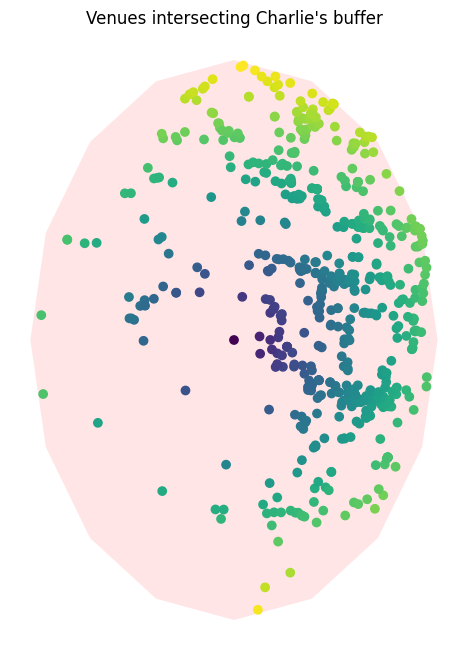

In [13]:
# Intersect bosnia places with our buffer computing the distance to Charlie's
query = f"""
    FROM places-bosnia
    | WHERE ST_INTERSECTS(
        TO_GEOSHAPE("{charlie_wkt}"),
        geometry
    )
    | EVAL dist_charlie = ST_DISTANCE(TO_GEOPOINT("{charlie_feature["geometry"]}"), geometry)
    | KEEP name, category, geometry, dist_charlie
    | LIMIT 50000
    """
venues = esql(query)

# Render the buffer and venues in a single plot
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

charlie_buffer.plot(ax=ax, color="red", alpha=0.1)
venues.plot(ax=ax, column="dist_charlie")
ax.set_title("Venues intersecting Charlie's buffer")
ax.set_axis_off()
plt.show()

## Using ES|QL for choropleth mapping

Let's use ES|QL to query a dataset of [OpenSky positions](https://opensky-network.org/) where each record has been reverse geocoded against the `ne_countries` dataset to assign a `country.iso_a2` field. The query will aggregate first by country and the run a `LOOKUP JOIN` to get the country geometries for local rendering.

In [17]:
# Let's first check a single position record
esql("""
FROM places-*
| WHERE addresses.country IS NOT NULL
| LIMIT 1
""").iloc[0]

,0
addresses.country,HR
addresses.freeform,Ulica Hrvoja Vukčića Hrvatinića 9
addresses.locality,Split
addresses.postcode,21000
addresses.region,NaN
alt_categories,"[cafe, fast_food_restaurant]"
brand,NaN
category,coffee_shop
confidence,0.566292
emails,NaN


In [18]:
# Check how many records are in the dataset
all_records = esql("""
FROM places-*
| STATS count = COUNT()
| KEEP count
""")['count'].iloc[0]

with_country = esql("""
FROM places-*
| WHERE addresses.country IS NOT NULL
| STATS count = COUNT()
| KEEP count
""")['count'].iloc[0]

print(f"Total records: {all_records:,}")
print(f"Records with country: {with_country:,}")

# NOTE:
# We can do the same computations directly with the Python client
# client.count(index="flight_tracking_*")['count']
# Add a filter to the count query to check if a field exists
# client.count(index="flight_tracking_*", body={"query": {"exists": {"field": "country.iso_a2"}}})['count']


Total records: 223,736
Records with country: 223,469


In [20]:
# Retrieve all countries for our simple basemap
all_countries = esql("FROM  ne_countries | KEEP iso_a2, name, geometry")

# Return the countries that intersect with the positions dataset
places_per_country = esql(
"""
// Get places
FROM places-*
// Filter those that were reverse geocoded into a country
| WHERE addresses.country IS NOT NULL

// Rename the join field to have the same name as the lookup table
| RENAME addresses.country AS iso_a2

// Aggregate the places by country
| STATS count = COUNT(),
        categories = COUNT_DISTINCT(category)
        BY iso_a2

// Join with the lookup table
| LOOKUP JOIN ne_countries ON iso_a2

// Remove dependencies with same iso_a2 than their main countries
| WHERE type NOT LIKE "Dependency"

| SORT count DESC
| KEEP iso_a2, count, categories, geometry
"""
)

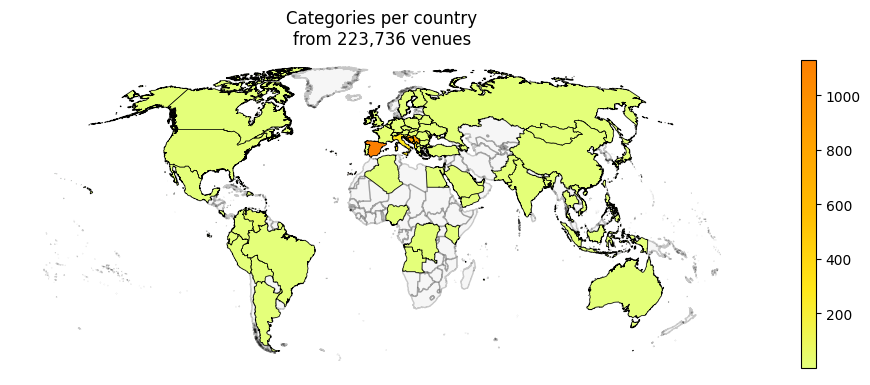

In [23]:
# Project the dataframes to the Robinson projection
all_countries_proj = all_countries.to_crs("ESRI:54030")
places_per_country_proj = places_per_country.to_crs("ESRI:54030")

# Render the places per country
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
all_countries_proj.plot(ax=ax, alpha=0.2, color="lightgrey", edgecolor="black")
places_per_country_proj.plot(
    ax=ax, column="categories", cmap="Wistia", legend=True, markersize=10,
    edgecolor="black", linewidth=0.5, legend_kwds={'shrink': 0.4}
)
ax.set_title(f"Categories per country\nfrom {all_records:,} venues")
ax.set_axis_off()
plt.show()